# Item to item based recommendation system based on product description

For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.

In [ ]:
# Importing libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
df = pd.read_csv('/content/amazon.csv')

In [ ]:
df.head(2)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...


In [ ]:
df.shape

(1465, 16)

In [ ]:
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df["product_name"].head(10)

0    Wayona Nylon Braided USB to Lightning Fast Cha...
1    Ambrane Unbreakable 60W / 3A Fast Charging 1.5...
2    Sounce Fast Phone Charging Cable & Data Sync U...
3    boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...
4    Portronics Konnect L 1.2M Fast Charging 3A 8 P...
5    pTron Solero TB301 3A Type-C Data and Fast Cha...
6    boAt Micro USB 55 Tangle-free, Sturdy Micro US...
7               MI Usb Type-C Cable Smartphone (Black)
8    TP-Link USB WiFi Adapter for PC(TL-WN725N), N1...
9    Ambrane Unbreakable 60W / 3A Fast Charging 1.5...
Name: product_name, dtype: object

Converting the text in product name into numerical data for analysis

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=ca88e8c635f78630ae673caefa3c548950705559c8b237c88211d449d1522709
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [ ]:
import nltk
import emoji
import re
#regular expression ... use for cleaning up
import string
from nltk.corpus import stopwords
# Remove useless words
from nltk.stem.lancaster import LancasterStemmer
#Convert words to base form; aggressive
# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#help us to split sentence into token

In [ ]:
# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply lambda functions to clean the specified columns
df["product_name"] = df["product_name"].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Apply removal of stopwords to the specified columns
df["product_name"] = df["product_name"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [ ]:
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

In [ ]:
df["product_name"] = df["product_name"].apply(stem)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')

In [ ]:
X1 = vectorizer.fit_transform(df["product_name"])

In [ ]:
X1

<1465x2531 sparse matrix of type '<class 'numpy.float64'>'
	with 20753 stored elements in Compressed Sparse Row format>

In [ ]:
X = X1

In [ ]:
# finding wcss value for different number of clusters

wcss = []

for i in range(1,21):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=15)
  kmeans.fit(X)

  wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


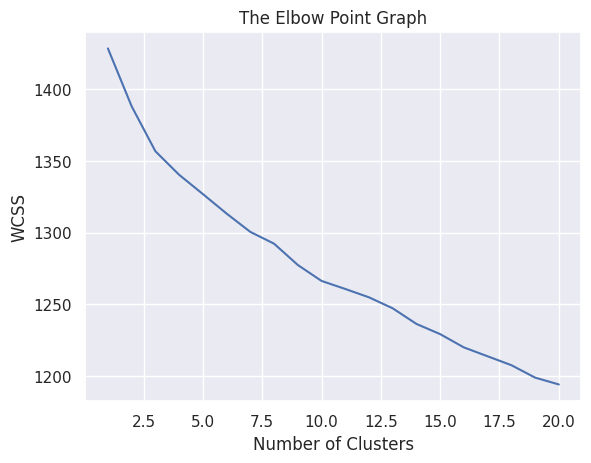

In [ ]:
# plot an elbow graph
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.plot(range(1,21), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


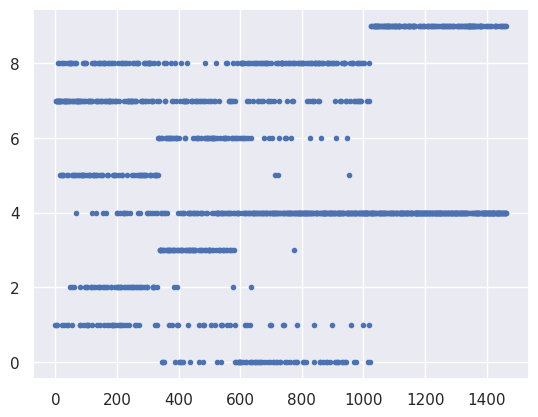

In [ ]:
# Fitting K-Means to the dataset
import matplotlib.pyplot as plt
X=X1
#init: Determines the initialization method for the centroids. 'k-means++' is a popular initialization method that improves the convergence of the algorithm.
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state=15)
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

Imagine you have a bunch of data points, like different houses with their areas and prices. You want to find groups of similar houses so you can understand the market better. K-means is like a smart way to do this.

true_k = 10: You decide you want to find 10 different groups of houses.

model = KMeans(...): You're setting up a special tool called K-means. It's like a machine that will group the houses for you. You're telling it to find 10 groups (n_clusters=true_k).

init='k-means++': This is how the tool starts. It carefully picks the first house to begin the groups.

max_iter=100: The tool will try to improve the groups by moving houses around up to 100 times. Imagine it rearranging the houses to make the groups better.

n_init=1: The tool will try this process once. But sometimes, the first try isn't the best, so you might try again with different starting points.

random_state=15: This makes sure that every time you use the tool, you get the same results. It's like using a fixed random number to make things predictable.

model.fit(X1): Now you're telling the tool to actually do the work. You give it the houses' data (X1) and it starts grouping them based on their similarities. It figures out which houses are similar and puts them in the same group.

In the end, you get 10 groups of houses, where the houses inside each group are similar to each other in terms of their areas and prices. This helps you understand the different types of houses in the market and make better decisions.

In [ ]:
#The print_cluster() function you provided prints the top terms for a given cluster
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
#The provided code is performing K-means clustering on the data (X1) and
#printing the top terms for each cluster.

true_k = 10
#max_iter: defines the maximum number of times the K-means algorithm will iterate to optimize the cluster centroids.
#n_init: Specifies the number of times the K-means algorithm will be run with different centroid seeds. It helps in finding better cluster assignments by avoiding poor initialization.
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1, random_state=15)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1] #Calculates the indices that would sort the cluster centers in descending order.
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 laptop
 mous
 wireless
 usb
 pc
 mac
 stand
 black
 adapt
 holder
Cluster 1:
 charg
 cabl
 usb
 fast
 data
 type
 sync
 meter
 braid
 micro
Cluster 2:
 watch
 sport
 mode
 rate
 monitor
 face
 smart
 bluetooth
 display
 smartwatch
Cluster 3:
 heater
 water
 room
 watt
 white
 geyser
 instant
 heat
 fan
 isi
Cluster 4:
 cm
 tv
 led
 inch
 hd
 smart
 seri
 android
 readi
 black
Cluster 5:
 ram
 storag
 batteri
 redmi
 galaxi
 upto
 snapdragon
 display
 iqoo
 samsung
Cluster 6:
 ear
 mic
 wire
 earphon
 headphon
 bluetooth
 boat
 bass
 basshead
 black
Cluster 7:
 type
 usb
 cabl
 charg
 charger
 fast
 samsung
 smartphon
 pro
 adapt
Cluster 8:
 electr
 kettl
 lint
 remov
 steel
 stainless
 egg
 boil
 coffe
 litr
Cluster 9:
 remot
 watt
 black
 mixer
 tv
 grinder
 jar
 white
 iron
 control


Imagine after using the K-means tool, you've grouped houses based on their similarities. Now, you want to see what makes each group unique, like what features (like size, price, etc.) are most important for each group. This is what this code does:

print("Top terms per cluster:"): It's like telling the computer that you want to see the important things for each group.

order_centroids = model.cluster_centers_.argsort()[:, ::-1]: Imagine you have a list of houses in each group. This line sorts these houses to show the most important ones first. It's like putting the most important houses at the top of the list.

terms = vectorizer.get_feature_names_out(): These are like the features of each house, things like size, price, etc. You're getting a list of these features.

for i in range(true_k):: This is like saying, "For each group I found earlier..."

print_cluster(i): You want to show the important houses for each group. You're telling the computer to show the important features of the houses in this group.

So, when you run this code, the computer will show you a list for each group. Each list will have the most important features at the top, helping you understand why the houses are in that group. It's like understanding why certain types of houses are grouped together based on their common features.

In [ ]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [ ]:
show_recommendations("heater")

Cluster 3:
 heater
 water
 room
 watt
 white
 geyser
 instant
 heat
 fan
 isi


In [ ]:
#The print_cluster() function you provided prints the top terms for a given cluster

def return_cluster(product):
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    return prediction[0]

In [ ]:
df2 = pd.read_csv('/content/amazon.csv')

In [ ]:
df2['cluster_id'] = df2['product_name'].apply(return_cluster)

In [ ]:
df2 = df2[['product_name', 'cluster_id','img_link']]

In [ ]:
df2[631:725]

,product_name,cluster_id,img_link
631,"Boult Audio Airbass Z20 True Wireless, 40H Bat...",6,https://m.media-amazon.com/images/I/31Hjf7KD75...
632,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,1,https://m.media-amazon.com/images/I/31VzNhhqif...
633,"SanDisk Ultra Flair 64GB USB 3.0 Pen Drive, Mu...",9,https://m.media-amazon.com/images/I/317Klchuxe...
634,"boAt Xtend Smartwatch with Alexa Built-in, 1.6...",2,https://m.media-amazon.com/images/W/WEBP_40237...
635,Tygot Bluetooth Extendable Selfie Sticks with ...,0,https://m.media-amazon.com/images/I/41MmsYTi06...
...,...,...,...
720,boAt Airdopes 171 in Ear Bluetooth True Wirele...,6,https://m.media-amazon.com/images/W/WEBP_40237...
721,Duracell Plus AAA Rechargeable Batteries (750 ...,9,https://m.media-amazon.com/images/I/418YrbHVLC...
722,tizum HDMI to VGA Adapter Cable 1080P for Proj...,9,https://m.media-amazon.com/images/I/31MIyzg8uz...
723,Samsung 80 cm (32 Inches) Wondertainment Serie...,4,https://m.media-amazon.com/images/I/51q3+E64az...


In [ ]:
df2['product_name'][724]

'Logitech B100 Wired USB Mouse, 3 yr Warranty, 800 DPI Optical Tracking, Ambidextrous PC/Mac/Laptop - Black'

In [ ]:
df2[df2['cluster_id']==2]['product_name'].count()

70

In [ ]:
df2[df2['cluster_id']==2].tail(30)

,product_name,cluster_id,img_link
517,Fire-Boltt Ninja 3 Smartwatch Full Touch 1.69 ...,2,https://m.media-amazon.com/images/I/41-IPkI1Y5...
525,"boAt Newly Launched Wave Electra with 1.81"" HD...",2,https://m.media-amazon.com/images/I/41LDspRanI...
545,SHREENOVA ID116 Plus Bluetooth Fitness Smart W...,2,https://m.media-amazon.com/images/I/41lnTFZGz9...
549,10WeRun Id-116 Bluetooth Smartwatch Wireless F...,2,https://m.media-amazon.com/images/I/41YwW+O-SK...
550,Tokdis MX-1 Pro Bluetooth Calling Smartwatch -...,2,https://m.media-amazon.com/images/I/31M4nb0+JK...
553,"Noise ColorFit Ultra 2 Buzz 1.78"" AMOLED Bluet...",2,https://m.media-amazon.com/images/I/41wlZ0cZCh...
559,Fire-Boltt Ninja 3 Smartwatch Full Touch 1.69 ...,2,https://m.media-amazon.com/images/I/41GwFR981C...
573,Noise ColorFit Pulse Grand Smart Watch with 1....,2,https://m.media-amazon.com/images/I/412dSHwBHG...
574,"Fire-Boltt Visionary 1.78"" AMOLED Bluetooth Ca...",2,https://m.media-amazon.com/images/I/41dtbrNRHd...
579,"Fire-Boltt Tank 1.85"" Bluetooth Calling Smart ...",2,https://m.media-amazon.com/images/I/41vQwUamFc...


In [ ]:
import pickle

In [ ]:
# Save the trained model to a file
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Save the vectorizer to a file
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [ ]:
df2.to_csv("testing.csv", index=False)